<h1>Movie Data EDA</h2>

<h2>Project for Phase 1 / Data Science at the Flatiron School</h2>
<h3>Notebook by Mike Roth</h3>

In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import time
import pyarrow.feather as feather

<h2>Load the scraped data from IMDB</h2>

<p>In a previous notebook, we scraped title data from imdb.com to get budget and box office info. Now, it's time to reload that data</p>

In [186]:
#load the feather file from the data we scraped from imdb.com

imdb_df = feather.read_feather('imdb_scrape_full.feather')

In [187]:
#display the dataframe to make sure everything is loaded

imdb_df.head()

,id,url,title,year,genre,certificate,runtime,imdb_rating,metascore,principals,director,creator,budget,domestic_box_office,worldwide_box_office,origin,genre_1,genre_2,genre_3
0,tt1477834,/title/tt1477834/,Aquaman,2018,"[Action, Adventure, Fantasy]",PG-13,143,6.8,55.0,"[{'id': 'nm0597388', 'name': 'Jason Momoa'}, {...","[{'id': 'nm1490123', 'name': 'James Wan'}]","[{'id': 'co0002663'}, {'id': 'co0283444'}, {'i...",160000000.0,335104314.0,1.148528e+09,"[United States, Australia]",Action,Adventure,Fantasy
1,tt1879016,/title/tt1879016/,Operation Mincemeat,2021,"[Drama, War]",PG-13,128,6.7,NaN,"[{'id': 'nm0000147', 'name': 'Colin Firth'}, {...","[{'id': 'nm0006960', 'name': 'John Madden'}]","[{'id': 'co0230132'}, {'id': 'co0243890'}, {'i...",NaN,NaN,1.228859e+07,"[United Kingdom, United States]",Drama,War,None
2,tt4513678,/title/tt4513678/,Ghostbusters: Afterlife,2021,"[Adventure, Comedy, Fantasy]",PG-13,124,7.1,45.0,"[{'id': 'nm4689420', 'name': 'Carrie Coon'}, {...","[{'id': 'nm0718646', 'name': 'Jason Reitman'}]","[{'id': 'co0050868'}, {'id': 'co0309252'}, {'i...",75000000.0,129360575.0,1.973606e+08,"[United States, Canada]",Adventure,Comedy,Fantasy
3,t10954652,/title/tt10954652/,Old,2021,"[Drama, Horror, Mystery]",PG-13,108,5.8,55.0,"[{'id': 'nm0305558', 'name': 'Gael García Bern...","[{'id': 'nm0796117', 'name': 'M. Night Shyamal...","[{'id': 'co0005073'}, {'id': 'co0054054'}, {'i...",NaN,48276510.0,9.014651e+07,"[United States, Japan]",Drama,Horror,Mystery
4,t10872600,/title/tt10872600/,Spider-Man: No Way Home,2021,"[Action, Adventure, Fantasy]",PG-13,148,8.3,NaN,"[{'id': 'nm4043618', 'name': 'Tom Holland'}, {...","[{'id': 'nm1218281', 'name': 'Jon Watts'}]","[{'id': 'co0050868'}, {'id': 'co0532247'}, {'i...",200000000.0,804747988.0,1.892748e+09,[United States],Action,Adventure,Fantasy


In [188]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5000 non-null   object 
 1   url                   5000 non-null   object 
 2   title                 5000 non-null   object 
 3   year                  5000 non-null   int64  
 4   genre                 5000 non-null   object 
 5   certificate           4508 non-null   object 
 6   runtime               5000 non-null   int64  
 7   imdb_rating           4999 non-null   float64
 8   metascore             1560 non-null   float64
 9   principals            4999 non-null   object 
 10  director              5000 non-null   object 
 11  creator               4995 non-null   object 
 12  budget                2429 non-null   float64
 13  domestic_box_office   2646 non-null   float64
 14  worldwide_box_office  3384 non-null   float64
 15  origin               

Looking at the info on the dataframe, we are missing a lot of rows from the budget and box office columns. We will want to eventually drop the rows that are missing BOTH budget and worldwide_box_office data so that we can metrics that will use those both. These will be the most important columns in our dataset.

We are also missing rows in the 2nd and 3rd genre columns, but we expect that since not every title has multiple genres.

<h2>Clean dataframe and add features</h2>

<p>First we will add features for the data we scraped.</p>

<p>We will want to compare new metrics from the budget and box office features, so we will create new columns.</p>

<p>The first two columns we want to create:</p>
<ul>
    <li>ROI - return of investment = worldwide box office / budget</li>
    <li>Profit = worldwide box office - budget</li>

In [357]:
imdb_df['roi'] = imdb_df.worldwide_box_office / imdb_df.budget
imdb_df['profit'] = imdb_df.worldwide_box_office - imdb_df.budget

In [372]:
imdb_df.sort_values('roi', ascending=False).head()

,id,url,title,year,genre,certificate,runtime,imdb_rating,metascore,principals,...,creator,budget,domestic_box_office,worldwide_box_office,origin,genre_1,genre_2,genre_3,roi,profit
3759,tt6032704,/title/tt6032704/,Apparition,2019,[Horror],None,83,3.0,NaN,"[{'id': 'nm0002546', 'name': 'Mena Suvari'}, {...",...,"[{'id': 'co0652466'}, {'id': 'nm0020811'}, {'i...",1.0,NaN,175038.0,[United States],Horror,None,None,175038.00000,175037.0
3196,tt2309260,/title/tt2309260/,The Gallows,2015,"[Horror, Mystery, Thriller]",R,81,4.2,NaN,"[{'id': 'nm3790547', 'name': 'Reese Mishler'},...",...,"[{'id': 'co0046718'}, {'id': 'co0098315'}, {'i...",100000.0,22764410.0,42964410.0,[United States],Horror,Mystery,Thriller,429.64410,42864410.0
870,tt8781414,/title/tt8781414/,Freaks,2018,"[Drama, Mystery, Sci-Fi]",R,105,6.7,NaN,"[{'id': 'nm0386472', 'name': 'Emile Hirsch'}, ...",...,"[{'id': 'co0708742'}, {'id': 'co0506709'}, {'i...",2000.0,276591.0,368410.0,"[United States, Canada]",Drama,Mystery,Sci-Fi,184.20500,366410.0
3004,tt1560985,/title/tt1560985/,The Devil Inside,2012,[Horror],R,83,4.2,NaN,"[{'id': 'nm1223326', 'name': 'Fernanda Andrade...",...,"[{'id': 'co0306248'}, {'id': 'co0342976'}, {'i...",1000000.0,53261944.0,101758490.0,[United States],Horror,None,None,101.75849,100758490.0
3848,tt2235779,/title/tt2235779/,The Quiet Ones,2014,"[Horror, Mystery, Thriller]",PG-13,98,5.1,41.0,"[{'id': 'nm0364813', 'name': 'Jared Harris'}, ...",...,"[{'id': 'co0234935'}, {'id': 'co0060069'}, {'i...",200000.0,8509867.0,17835162.0,"[United Kingdom, United States]",Horror,Mystery,Thriller,89.17581,17635162.0


<h2>Clean, clean, clean</h2>

<p>Let's drop rows that have no values for budget and worldwide_box_office</p>
<p>Also, we will extract the first value for each list in principals (actors in a movie) and the list of directors</p>

In [359]:
#extract first principal and first director from their respective lists
imdb_budgets = imdb_df.loc[:]
imdb_budgets.dropna(subset=['budget','worldwide_box_office'], inplace=True)
imdb_budgets['main_principal'] = imdb_budgets.principals.map(lambda x : x[0]['name'])
imdb_budgets['main_director'] = imdb_budgets.director.map(lambda x : x[0]['name'])

#we can drop columns we aren't using anymore. note: all movies we searched for in the scrape were from USA, so we can
#drop the origin column
imdb_budgets = imdb_budgets.drop(['id','url','metascore','genre','principals','director', 'origin'], axis=1) 

#filter out budgets less than $1000
imdb_budgets = imdb_budgets[imdb_budgets.budget > 1000]

imdb_budgets.reset_index(inplace=True, drop=True)
imdb_budgets.head()

,title,year,certificate,runtime,imdb_rating,creator,budget,domestic_box_office,worldwide_box_office,genre_1,genre_2,genre_3,roi,profit,main_principal,main_director
0,Aquaman,2018,PG-13,143,6.8,"[{'id': 'co0002663'}, {'id': 'co0283444'}, {'i...",160000000.0,335104314.0,1.148528e+09,Action,Adventure,Fantasy,7.178302,9.885284e+08,Jason Momoa,James Wan
1,Ghostbusters: Afterlife,2021,PG-13,124,7.1,"[{'id': 'co0050868'}, {'id': 'co0309252'}, {'i...",75000000.0,129360575.0,1.973606e+08,Adventure,Comedy,Fantasy,2.631474,1.223606e+08,Carrie Coon,Jason Reitman
2,Spider-Man: No Way Home,2021,PG-13,148,8.3,"[{'id': 'co0050868'}, {'id': 'co0532247'}, {'i...",200000000.0,804747988.0,1.892748e+09,Action,Adventure,Fantasy,9.463740,1.692748e+09,Tom Holland,Jon Watts
3,The Rum Diary,2011,R,119,6.1,"[{'id': 'co0209646'}, {'id': 'co0135149'}, {'i...",45000000.0,13109815.0,3.013496e+07,Comedy,Drama,None,0.669666,-1.486504e+07,Johnny Depp,Bruce Robinson
4,The Lincoln Lawyer,2011,R,118,7.3,"[{'id': 'co0173285'}, {'id': 'co0005323'}, {'i...",40000000.0,58009200.0,8.675235e+07,Crime,Drama,Mystery,2.168809,4.675235e+07,Matthew McConaughey,Brad Furman


<h2>Get studio names</h2>

<p>We have no names of directors from the imdb page, so we will have to run a new scraper to get those names. First, we will create a set of the unique studio id's from the data frame. Then, we will scrape imdb.com again to get the names connected to those id's.</p>

In [360]:
#let's get a dictionary of unique creator names in the dataset

creators = dict()
for row in imdb_budgets.creator:
    try:
        for dict_ in row:
            if dict_['id'][:2] == 'co':
                if dict_['id'] not in creators.keys():
                    creators[dict_['id']] = 1
                else:
                    creators[dict_['id']] += 1
    except:
        print(f'error for {dict_}')

In [300]:
#scrape imdb for the name of the creator based on the id
creator_names = {}
for i, id_ in enumerate(list(creators.keys())):
    r = requests.get(f'https://www.imdb.com/search/title/?companies={id_}')
    soup = BeautifulSoup(r.text, 'html.parser')
    name = soup.title.text.replace('With ','').replace('\n(Sorted by Popularity Ascending) - IMDb', '')
    creator_names[id_] = name
    time.sleep(.25)
    print(f'getting name of creator {i+1} / {len(list(creators.keys()))}', end='\r')

In [319]:
#confirm scraper worked

len(creator_names)

2129

In [320]:
#we will use this helper function to match the creator id's with the creator names we just scraped from imdb.com
#and create a new column in the df with the first name in the list

def get_creator_name(creators_list):
    for creator in creators_list:
        if creator['id'][:2] == 'co':
            return creator_names[creator['id']]

In [361]:
imdb_budgets['main_creator'] = imdb_budgets.creator.map(get_creator_name)

In [362]:
#we don't need the creator column anymore, so let's drop it
imdb_budgets = imdb_budgets.drop('creator', axis=1)
imdb_budgets.head()

,title,year,certificate,runtime,imdb_rating,budget,domestic_box_office,worldwide_box_office,genre_1,genre_2,genre_3,roi,profit,main_principal,main_director,main_creator
0,Aquaman,2018,PG-13,143,6.8,160000000.0,335104314.0,1.148528e+09,Action,Adventure,Fantasy,7.178302,9.885284e+08,Jason Momoa,James Wan,Warner Bros.
1,Ghostbusters: Afterlife,2021,PG-13,124,7.1,75000000.0,129360575.0,1.973606e+08,Adventure,Comedy,Fantasy,2.631474,1.223606e+08,Carrie Coon,Jason Reitman,Columbia Pictures
2,Spider-Man: No Way Home,2021,PG-13,148,8.3,200000000.0,804747988.0,1.892748e+09,Action,Adventure,Fantasy,9.463740,1.692748e+09,Tom Holland,Jon Watts,Columbia Pictures
3,The Rum Diary,2011,R,119,6.1,45000000.0,13109815.0,3.013496e+07,Comedy,Drama,None,0.669666,-1.486504e+07,Johnny Depp,Bruce Robinson,GK Films
4,The Lincoln Lawyer,2011,R,118,7.3,40000000.0,58009200.0,8.675235e+07,Crime,Drama,Mystery,2.168809,4.675235e+07,Matthew McConaughey,Brad Furman,Lionsgate


<h2>Backup dataframe to file</h2>

<p>Things are pretty clean at this point, and in case we have to close the notebook, let's save the dataframe so we don't have to run any scrapers again.</p>

In [368]:
#this dataframe is what we want to use so let's save it just for the sake of our sanity

feather.write_feather(imdb_budgets, 'imdb_budgets_clean.feather')

<h3>We can run the cell below, if we just want to load the dataframe that we created, without scraping again.</h3>

In [371]:
#uncomment and reload the dataframe from the file if we don't want to run all the scrapers again

#imdb_budgets = feather.read_feather('imdb_budgets_clean.feather')

<h1>EDA</h1>

<p>In this section, we will begin our EDA of the movie data that we have created. Let's begin with stating the questions we are looking answers for.</p>
   <br>
    
<ul>
    <li><h2>Question 1</h2><h3>What genres of movies are the most profitable?</h3>
    <p>Are specific genres of movies more profitable than others? We will explore both ROI and Profit by genre.</p>
    </li>
</ul>
    
<ul>
    <li><h2>Question 2</h2><h3>Can a studio focus on specific genres and still be profitable</h3>
    <p>Does the variance of genre from any studio have an effect on the profitability</p>
    </li>
</ul>
    
<ul>
    <li><h2>Question 3</h2><h3>What actors/directors/studios never make unprofitable movies?</h3>
    <p>Do specific artists and creators have a relationship with profitability (or loss)?</p>
    </li>
</ul>
<br>

<h2>So let's begin...</h2>

<h1>Question 1 - Genre Profitability</h1>

<p>We'll begin by looking at what genres are the most profitable (for ROI and gross profit). Each title has up to 3 different genres that were sorted by alphabetical order on imdb.com. We have extracted those genres to columns: genre_1, genre_2, and genre_3.

Since genre 1 does not necessarily mean that it is the most important genre compared to genre_2 or genre_3, we will
have to make our genre comparison a little more complicated before we can view it simply. Let's first get a set of 
the unique genre values

In [426]:
genre_list = set()
for i in range(3):
    for val in imdb_budgets[f'genre_{i+1}'].unique():
        if val != None:
            genre_list.add(val) 

Now that we have a list of the unique values in the genre columns, let's find the roi and profit (mean and median) for every title that has that contains that genre. Some titles have up to 3 genres, so in a sense the mean and median values will be aggregated from titles that are also aggregatted in multiple other genres.

In [490]:
genre_mean_roi = {}
genre_median_roi = {}
genre_mean_profit = {}
genre_median_profit = {}
genre_count = {}

for genre in genre_list:
    genre_count[genre] = imdb_budgets.query(f'genre_1 == "{genre}" or genre_2 == "{genre}" or genre_3 == "{genre}"').roi.count()
    genre_mean_roi[genre] = imdb_budgets.query(f'genre_1 == "{genre}" or genre_2 == "{genre}" or genre_3 == "{genre}"').roi.mean()
    genre_median_roi[genre] = imdb_budgets.query(f'genre_1 == "{genre}" or genre_2 == "{genre}" or genre_3 == "{genre}"').roi.median()
    genre_mean_profit[genre] = imdb_budgets.query(f'genre_1 == "{genre}" or genre_2 == "{genre}" or genre_3 == "{genre}"').profit.mean()
    genre_median_profit[genre] = imdb_budgets.query(f'genre_1 == "{genre}" or genre_2 == "{genre}" or genre_3 == "{genre}"').profit.median()
    
genre_data = [x for x in zip(genre_mean_roi.keys(),genre_mean_roi.values(),genre_median_roi.values(),genre_mean_profit.values(),genre_median_profit.values(),genre_count.values())]
genre_df = pd.DataFrame(genre_data, columns=['genre', 'mean_roi', 'median_roi', 'mean_profit', 'median_profit', 'num']).sort_values('mean_roi', ascending=False).reset_index(drop=True)


In [688]:
genre_df.head()

,genre,mean_roi,median_roi,mean_profit,median_profit,num
0,Mystery,9.952102,2.601883,5.532572e+07,15897377.0,208
1,Horror,8.338068,2.303754,4.672115e+07,13399629.5,274
2,Thriller,5.230860,1.377300,5.948022e+07,5140084.0,406
3,Sci-Fi,4.530426,2.459817,2.175493e+08,77669379.0,183
4,Music,3.609881,1.837317,6.571519e+07,14272382.0,48


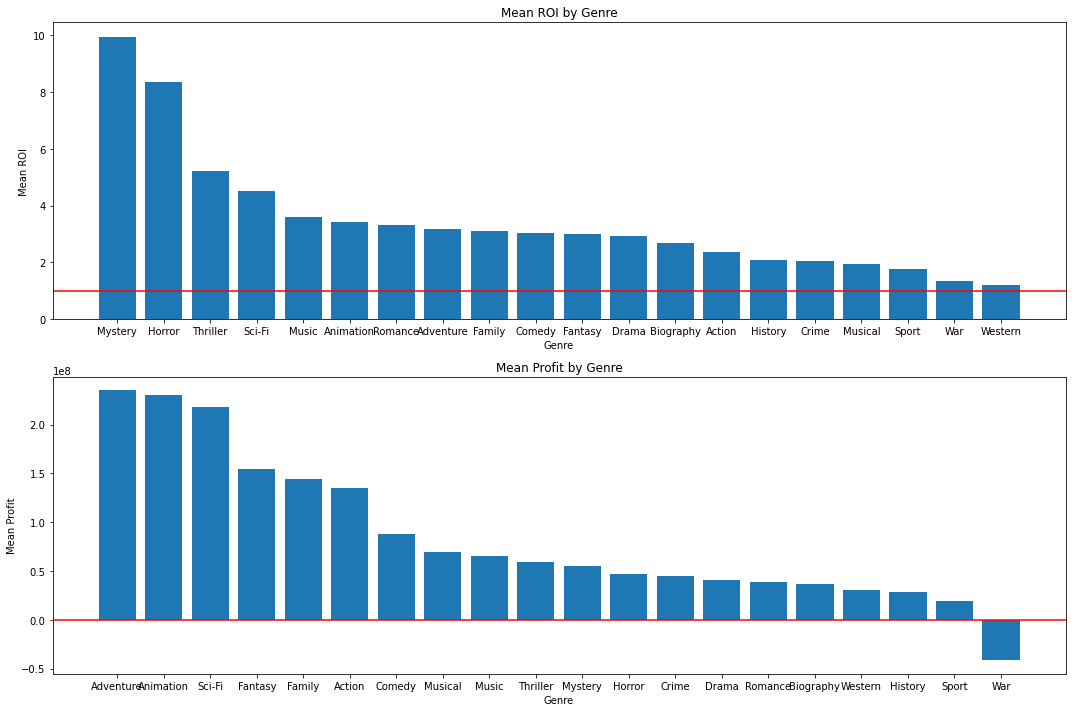

In [793]:
fig, ax = plt.subplots(2,figsize=(15,10))
ax[0].bar(genre_df.genre, genre_df.mean_roi)
ax[0].axhline(1,color='red')
ax[0].set_title('Mean ROI by Genre')
ax[0].set_ylabel('Mean ROI')
ax[0].set_xlabel('Genre')
ax[1].bar(genre_df.sort_values('mean_profit', ascending=False).genre, genre_df.sort_values('mean_profit', ascending=False).mean_profit)
ax[1].axhline(0,color='red')
ax[1].set_title('Mean Profit by Genre')
ax[1].set_ylabel('Mean Profit')
ax[1].set_xlabel('Genre')

plt.tight_layout()
plt.show()

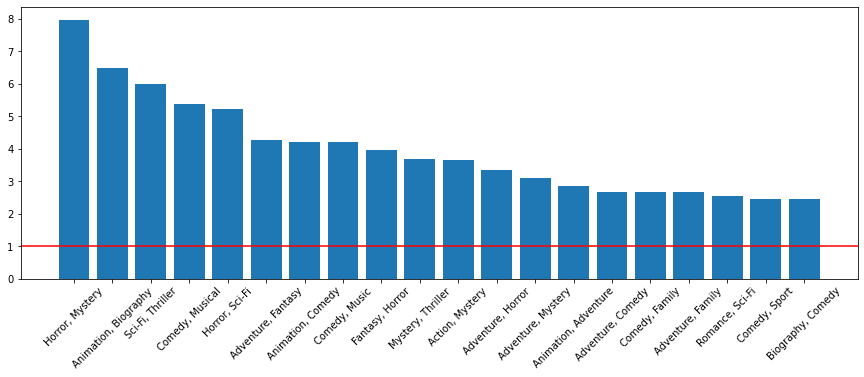

In [789]:
roi_by_double_genre = imdb_budgets.groupby(['genre_1','genre_2'])['roi'].median().sort_values(ascending=False)[:20]

fig, ax = plt.subplots(figsize = (15,5))
ax.bar([x[0] +', ' + x[1] for x in roi_by_double_genre.index], roi_by_double_genre)
ax.set_title('')
ax.axhline(1, color='red')
plt.xticks(rotation = 45)
plt.show()


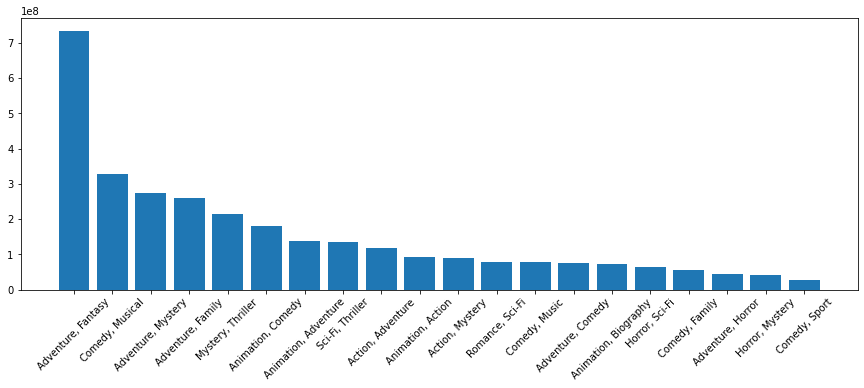

In [792]:
profit_by_double_genre = imdb_budgets.groupby(['genre_1','genre_2'])['profit'].median().sort_values(ascending=False)[:20]
fig, ax = plt.subplots(figsize = (15,5))
ax.bar([x[0] +', ' + x[1] for x in profit_by_double_genre.index], profit_by_double_genre)
ax.set_title('')
plt.xticks(rotation = 45)
plt.show()


In [540]:
imdb_budgets.groupby('genre_1')['worldwide_box_office'].mean().sort_values(ascending=False)

genre_1
Animation    3.171519e+08
Adventure    2.500924e+08
Action       2.064891e+08
Sci-Fi       1.618495e+08
Mystery      8.041151e+07
Horror       6.817382e+07
Comedy       6.252497e+07
Biography    5.879309e+07
Crime        4.983007e+07
Drama        4.668279e+07
Romance      3.537565e+07
Fantasy      3.010476e+07
Thriller     1.664062e+07
Music        7.975812e+06
Musical      2.827489e+06
Name: worldwide_box_office, dtype: float64

In [541]:
genre_by_genre = imdb_budgets.groupby(['genre_1', 'genre_2'])['profit'].mean().sort_values(ascending=False)

<AxesSubplot:xlabel='genre_2', ylabel='genre_1'>

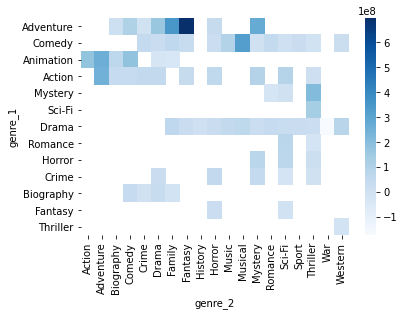

In [543]:
sns.heatmap(genre_by_genre.unstack(), cmap='Blues')

<h1>Question 2 - Studio Profitability</h1>

<h3>What makes a studio profitable? Can a studio make a larger profit or larger ROI while focusing on a small set of genres?</h3>

<p>Let's explore these questions in this next section. First, let's slice the rows of titles from studios that have made more than 5 features.</p>

In [648]:
#slice a copy of the dataframe for titles from studios that have made more than 5 features
studios_with_more_than_5_features = pd.DataFrame(imdb_budgets.groupby('main_creator').filter(lambda x: len(x) > 5))
studios_genre_df = pd.DataFrame()
studios_genre_df['studio'] = studios_with_more_than_5_features.groupby('main_creator')['genre_1'].unique().index

#create lists of all the genres in each genre column
genre_1 = studios_with_more_than_5_features.groupby('main_creator')['genre_1'].unique().values
genre_2 = studios_with_more_than_5_features.groupby('main_creator')['genre_2'].unique().values
genre_3 = studios_with_more_than_5_features.groupby('main_creator')['genre_3'].unique().values

#create sets from the lists so we only get unique values
studio_genre_sets = []
for i, list_ in enumerate(list(zip(genre_1,genre_2,genre_3))):
    genre_set = set()
    for sublist in list_:
        for item in sublist:
            if item != None:
                genre_set.add(item)
    studio_genre_sets.append(list(genre_set))
    
#save the aggregate data to a DataFrame    
studios_genre_df['genres'] = studio_genre_sets
studios_genre_df['genre_count'] = studios_genre_df['genres'].map(lambda x: len(x))
studios_genre_df['mean_roi'] = studios_with_more_than_5_features.groupby('main_creator').roi.mean().values
studios_genre_df['mean_profit'] = studios_with_more_than_5_features.groupby('main_creator').profit.mean().values

In [676]:
#sort by Mean ROI and display first 5 rows
studios_genre_df.sort_values('mean_roi',ascending=False, inplace=True)
studios_genre_df.reset_index(drop=True, inplace=True)
studios_genre_df.head()

,studio,genres,genre_count,mean_roi,mean_profit
0,New Line Cinema,"[Music, Musical, Drama, Romance, Horror, Adven...",13,18.621633,1.678181e+08
1,FilmDistrict,"[Drama, Horror, Adventure, Comedy, Action, Cri...",8,15.933050,4.188916e+07
2,Exclusive Media Group,"[Music, Drama, Horror, Biography, Adventure, H...",11,13.422121,2.258175e+07
3,Blumhouse Productions,"[Drama, Horror, Adventure, Comedy, Sci-Fi, Act...",10,8.565661,4.973896e+07
4,Screen Gems,"[Music, Musical, Drama, Romance, Horror, Adven...",12,7.031407,5.144489e+07


In [685]:
#example of the list of genres in the first row of data
print(studios_genre_df.loc[0,'studio'], studios_genre_df.loc[0,'genres'])

New Line Cinema ['Music', 'Musical', 'Drama', 'Romance', 'Horror', 'Adventure', 'Comedy', 'Fantasy', 'Sci-Fi', 'Action', 'Crime', 'Mystery', 'Thriller']


<h2>Visualize the Mean ROI per Title by Studio</h2>

Let's plot the Mean ROI per title of each studio against the number of genres that studio produces.

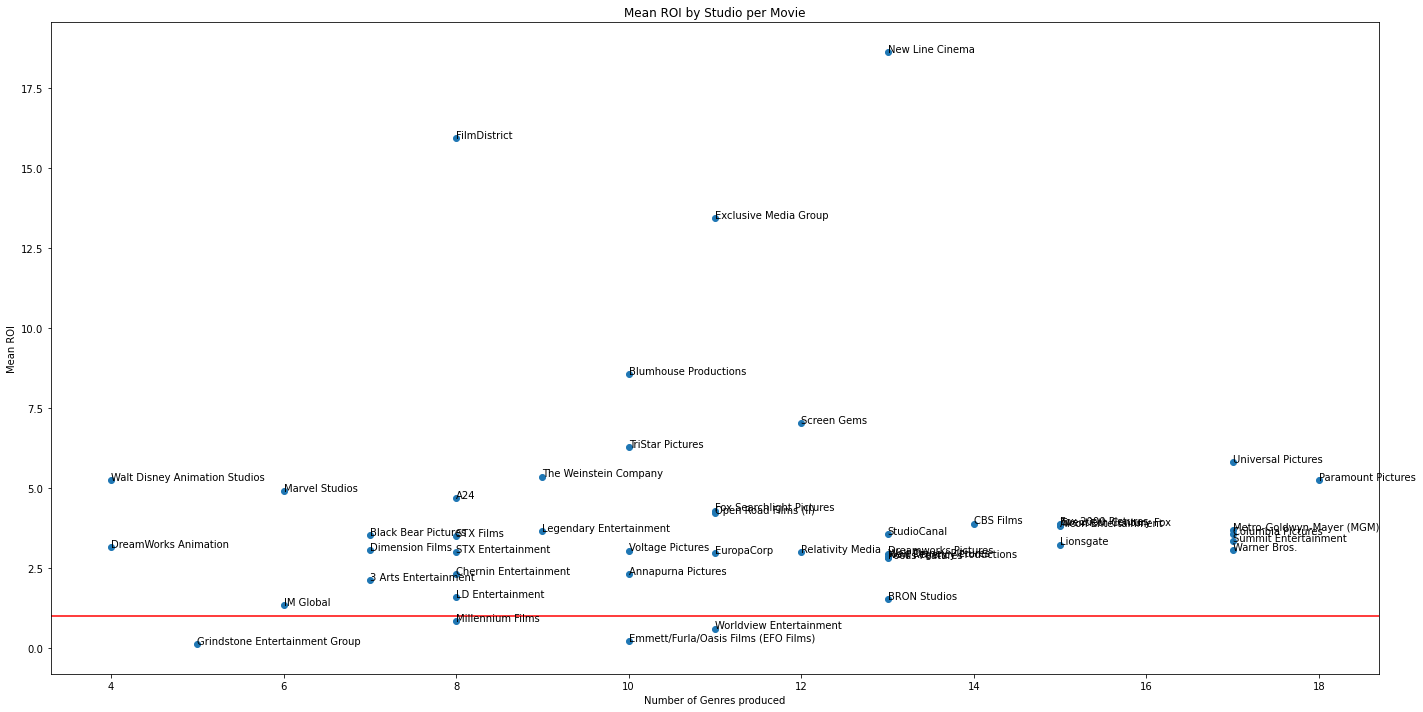

In [678]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(studios_genre_df.genre_count, studios_genre_df.mean_roi)
ax.axhline(1, color='red')
for i, txt in enumerate(studios_genre_df.studio):
    ax.annotate(txt, (studios_genre_df.genre_count[i], studios_genre_df.mean_roi[i]))
ax.set_title('Mean ROI by Studio per Movie')
ax.set_ylabel('Mean ROI')
ax.set_xlabel('Number of Genres produced')
plt.tight_layout()
plt.show()

Ok it looks like there is not much of a pattern here. Studios that have produced many genres are about as profitable as ones that have focused on less. Another thing we notice is that most of the studio have an mean ROI that is profitable (ROI > 1).

<h2>Visualize the Mean Profit per Title by Studio</h2>

What we really want to see is the max mean profit of each studio. Let's plot the Mean Profit per title of each studio against the number of genres that studio produces.

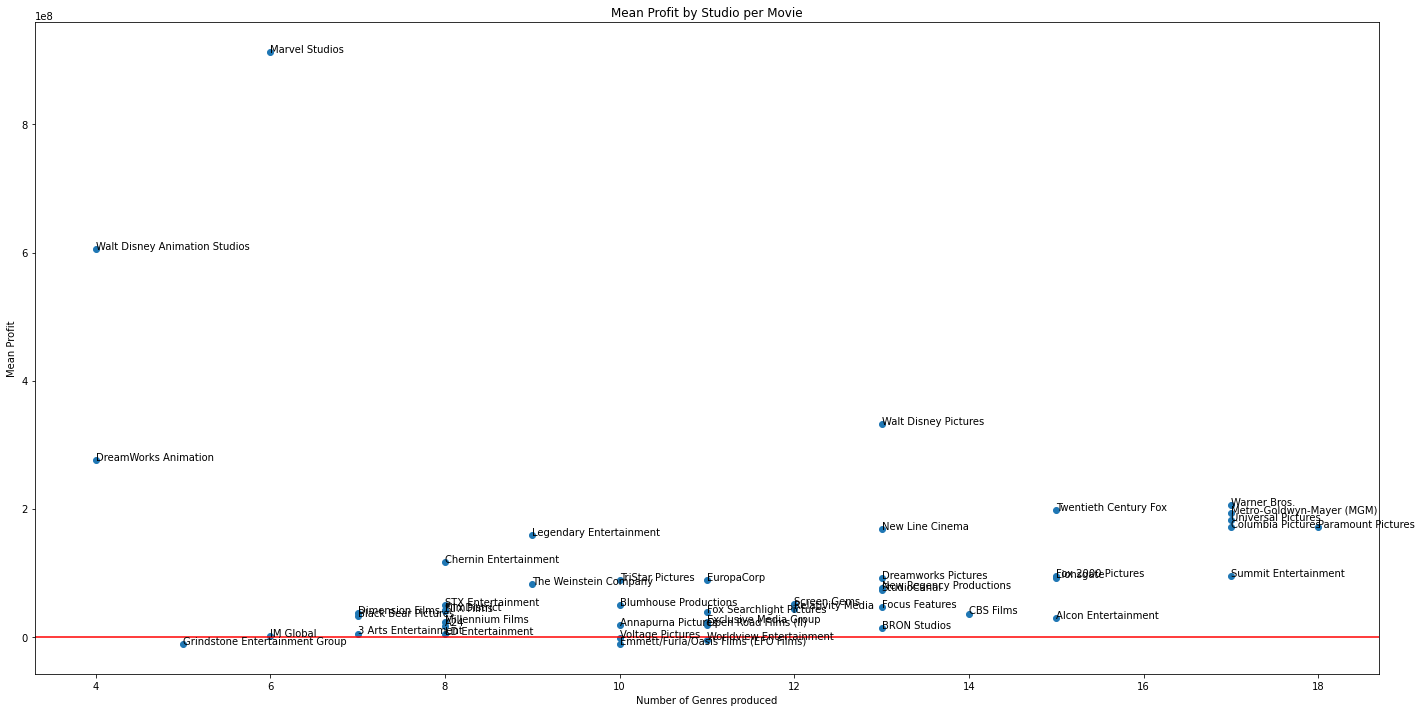

In [687]:
fig, ax = plt.subplots(figsize=(20,10))
ax.scatter(studios_genre_df.genre_count, studios_genre_df.mean_profit)
ax.axhline(1, color='red')
for i, txt in enumerate(studios_genre_df.studio):
    ax.annotate(txt, (studios_genre_df.genre_count[i], studios_genre_df.mean_profit[i]))
ax.set_title('Mean Profit by Studio per Movie')
ax.set_ylabel('Mean Profit')
ax.set_xlabel('Number of Genres produced')
plt.tight_layout()
plt.show()

In this graph it seems the data is a bit more clustered than before. There is a slight relationship in studio profitability and number of genres produced. While on the other hand, the studios with the least number of genres have some of the most profitable titles on average.

<h1>Question 2 - Artist Profitability</h1>

<h3>What kinds of actors/actresses and directors are the most profitable when attached to a title?</h3>

More specifically, what actors/actresses never fail to make a profit on a movie when they are top billing?

In [731]:
actors_with_3_features = imdb_budgets.groupby('main_principal').filter(lambda x: len(x) > 2)

<h2>Top 10 Actors/Actresses with Top Billing by Mean ROI per title, who always delivered</h2>

Displaying actors and actresses with at least 3 titles between 2010-2021, whose ROI was always profitable (ROI > 1).

In [741]:
actors_with_total_positive_roi = actors_with_3_features.groupby('main_principal').filter(lambda x: x.roi.min() > 1)
actors_with_total_positive_roi.groupby('main_principal').roi.mean().sort_values(ascending=False)[:10]

main_principal
Marlon Wayans        11.616338
Dakota Johnson        7.724564
Michael B. Jordan     7.644341
Felicity Jones        7.542573
Ryan Gosling          7.115818
Shailene Woodley      7.007629
Seth Rogen            6.856722
Judi Dench            6.703812
Jennifer Lopez        6.612824
Mila Kunis            6.044104
Name: roi, dtype: float64

<h2>Nice job!</h2>
<div style='display:flex;'>
    <div width="28%" style='margin:2%;text-align:center'><img src="img/wayans.png" style="width:auto;height:300px"/>Marlon Wayans</div>
    <div width="28%" style='margin:2%;text-align:center'><img src="img/dakotajohnson.jpg" style="width:auto;height:300px"/>Dakota Johnson</div>
    <div width="28%" style='margin:2%;text-align:center'><img src="img/michaelbjordan.jpg" style="width:auto;height:300px"/>Michael B Jordan</div>
</div>

<h3>Top Actors/Actresses with Top Billing by Mean ROI per title, who never have a profitable title</h3>

Displaying actors and actresses with at least 3 titles between 2010-2021, whose ROI was always unprofitable.

In [759]:
actors_with_total_negative_roi = actors_with_3_features.groupby('main_principal').filter(lambda x: x.roi.max() < 1)
actors_with_total_negative_roi.groupby('main_principal').roi.mean().sort_values(ascending=False)[:10]

main_principal
Charlie Hunnam    0.539979
Amber Heard       0.198525
Clive Owen        0.180617
Scott Adkins      0.065143
Name: roi, dtype: float64

<h2>Top 10 Director by Mean ROI per title, who always made a profit between 2010-2021</h2>

Displaying directors with more than 2 titles between 2010-2021, whose ROI is always profitable (ROI > 1).

In [753]:
directors_with_3_features = imdb_budgets.groupby('main_director').filter(lambda x: len(x) > 3)

In [765]:
directors_with_total_positive_roi = directors_with_3_features.groupby('main_director').filter(lambda x: x.roi.min() > 1)
directors_with_total_positive_roi.groupby('main_director').roi.mean().sort_values(ascending=False)[:10]

main_director
James Wan             22.995862
M. Night Shyamalan    13.396942
Jake Kasdan            7.764253
Todd Phillips          7.159705
Tate Taylor            6.462563
Bryan Singer           6.328846
Anthony Russo          5.763791
David Yates            5.406219
Will Gluck             5.241265
J.J. Abrams            5.003690
Name: roi, dtype: float64

<h2>Make that money!</h2>
<div style='display:flex;margin:auto;'>
    <div width="28%" style='margin:2%;text-align:center'><img src="img/aquaman.jpg" style="width:auto;height:300px"/>Directed by James Wan</div>
    <div width="28%" style='margin:2%;text-align:center'><img src="img/split.jpg" style="width:auto;height:300px"/>Directed by M. Night Shyamalan</div>
    <div width="28%" style='margin:2%;text-align:center'><img src="img/jumanji.jpg" style="width:auto;height:300px"/>Directed by James Kasdan</div>
</div>

<h3>Top Directors by Mean ROI per title, who never have a profitable title</h3>

Displaying actors and actresses with at least 3 titles between 2010-2021, whose ROI is always unprofitable.

In [783]:
directors_with_total_negative_roi = directors_with_3_features.groupby('main_director').filter(lambda x: x.roi.max() < 1)
directors_with_total_negative_roi.groupby('main_director').roi.mean().sort_values(ascending=False)[:10]

main_director
Steven C. Miller    0.103815
John Stockwell      0.034020
Name: roi, dtype: float64